[Go to this directory index](./)

Contents
  - [Optimization method 2.5 parametric studies¶](#Optimization-method-2.5-parametric-studies)
      - [Trial 2.5¶](#Trial-2.5)
  - [Scratch work¶](#Scratch-work)

# Optimization method 2.5 parametric studies

Previously, I obtained reasonable convergence on optima using a two-step strategy: first, simply enforce feasibility and optimize cooling output without regard to cost; then for any given cooling output goal less than the maximum, enforce that as a constraint and optimize system cost (from size and flow parameters). With some art in selecting constraint functions, I implemented this using the COBYLA optimization routine.

Since that method can be made to work, let's do a parametric study in two parameters: temperature for heat rejection (T) and cost (UA). For each heat reject temperature, we will determine the maximum cooling (Q_max), then build a cost vs cooling curve. The data should form a surface of points (T,UA,Q). We can also visualize that surface by projecting and plotting isolines, for example, isolines of UA on a (T,Q) plot.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import numpy
from IPython.display import HTML, SVG, clear_output

In [3]:
#matplotlib.use('svg')
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.sans-serif'] = 'Arial'

In [4]:
from io import BytesIO
def pltsvg():
    imgdata = BytesIO()
    plt.savefig(imgdata)
    imgdata.seek(0)
    display(SVG(data=imgdata.read()))

In [5]:
import ammonia1
import system_aqua1
import scipy.optimize

In [6]:
def saturate(x, bottom=-numpy.inf, top=0):
    a_bottom = numpy.empty_like(x)
    a_top = numpy.empty_like(x)
    a_bottom.fill(bottom)
    a_top.fill(top)
    return numpy.minimum(a_top,
                         numpy.maximum(a_bottom,
                                       x))

def barrier1(c, length_scale):
    """The domain for B is the feasible set only.
    We want B large near boundary, but small elsewhere.
    Feasible means c > 0 and g < 0. Please input c.
    """
    g = numpy.negative(c)
    b = numpy.exp(g / length_scale)
    return numpy.sum(b)

def decay1(step_number, initial_value = 1., rate = 1.):
    """A decaying function to scale barrier functions.
    step_number: as this increases, I decay.
    initial_value: value when step_number = 0.
    decay_rate: how fast to decay.
    """
    # Magnitude tends to zero, slowly
    mu_B = initial_value * numpy.exp(-rate * step_number)
    return mu_B        

def penalty1(c, length_scale):
    """We want P = 0 for feasible, P > 0 elsewhere
    Feasible means c > 0 and g < 0.
    """
    g = numpy.negative(c)
    g = saturate(g,bottom=0,top=numpy.inf)
    p = (g / length_scale)**2
    return numpy.sum(p)

def grow1(step_number, initial_value = 1., rate = 1.):
    """A growing function to scale penalty functions."""
    # Magnitude tends to infinite, bit more quickly
    mu_P = initial_value * numpy.exp(rate * step_number)
    return mu_P


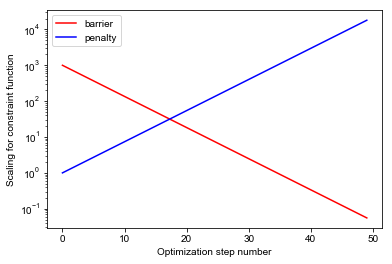

In [16]:
step_number = numpy.arange(50)
mu_B = decay1(step_number,initial_value=1000,rate=0.2)
mu_P = grow1(step_number,initial_value=1,rate=0.2)
plt.close('all')
plt.figure()
plt.semilogy(step_number,mu_B,'r',label='barrier')
plt.semilogy(step_number,mu_P,'b',label='penalty')
plt.xlabel('Optimization step number')
plt.ylabel('Scaling for constraint function')
plt.legend()
plt.show()

### Trial 2.5
An extension of a previous idea, kind of the dual problem -- Perform optimization in two steps: first with no constraint on UA (cost) to determine maximum Q (output). Then for each Q in a set of lesser values, optimize with respect to cost. This will deliver an optimal cost vs output curve.

For the first step, since we are not interested in UA, we can be less strict with the constraints on heat exchange feasibility. Specifically, we can impose them via penalty constraints instead of barrier constraints.

In [21]:
class Problem_2_5_A:
    def __init__(self, bdry, mu=0.1):
        self.bdry = bdry
        self.mu = mu
        self.Ncons = 7
        self.n_calls = 0
        # Soft constraints mode: this is sent to minimizer
        self.constraints = [{'type': 'ineq',
                             'fun': self.constraint,
                             'args': (i,)
                            } for i in range(self.Ncons)]
            
    def objective(self, xC):
        step_number = numpy.floor(self.n_calls / 7)
        self.n_calls += 1
        # print(xC,flush=True)
        Q,B,P = 0.,0.,0.
        try:
            ch = system_aqua1.makeChiller(xC)
            sys = system_aqua1.System(self.bdry, ch)
            
            # Barriers
            # Magnitude tends to zero, slowly
            mu_B = 1000. * numpy.exp(-0.1 * step_number)
            length_scale_b = 1
            # Or ... magnitude fixed, but shape changes
            mu_B = 1000
            length_scale_b = 1 * numpy.exp(-0.1 * step_number)
            
            # These are zero at the boundary ...
            barriers = [ch.check_rectifier_delta_T]                        
            B = mu_B * barrier1(barriers,length_scale_b)
            
            # Penalties
            # Magnitude tends to infinite
            mu_P = 1 * numpy.exp(0.3 * step_number)
            penalties = [deltaT - 0.01
                         for name, deltaT, epsilon, UA, Qhx in sys.data]
            P = mu_P * penalty1(penalties,1)
            
            Q = sys.chiller.Q_evap
        except KeyboardInterrupt as e:
            raise e
        except:
            Q = numpy.inf
        
        print(self.n_calls, step_number, Q, B, P, "\n", flush=True)
        return -Q + B + P
    
    def constraint(self, x, *args):
        cons = [x[0] - 0.1,
                1. - x[0],
                x[2] - x[1] - 1.0,
                x[3] - x[2] - 0.1,
                x[4] - x[1] - 10.0,
                x[5] - x[3] - 1.0,
                x[5] - x[4] - 1.0]
        if len(args) > 0:
            i, = args
            return cons[i]
        else:
            return cons

    def callback(self, x):
        print("Did an iteration at ", x)

In [41]:
class Problem_2_5_B:
    def __init__(self, bdry, Q_goal, mu=0.1):
        self.bdry = bdry
        self.Q_goal = Q_goal
        self.mu = mu
        self.Ncons = 7
        self.n_calls = 0
        # Soft constraints mode: this is sent to minimizer
        self.constraints = [{'type': 'ineq',
                             'fun': self.constraint,
                             'args': (i,)
                            } for i in range(self.Ncons)]
            
    def objective_raw(self, xC):
        try:
            ch = system_aqua1.makeChiller(xC)
            sys = system_aqua1.System(self.bdry, ch)
            UA = sys.totalUA
        except:
            UA = numpy.nan
        return UA

        
    def objective(self, xC):
        step_number = numpy.floor(self.n_calls / 7)
        self.n_calls += 1
        #print(xC,flush=True)
        UA,B,P = 0.,0.,0.
        try:
            ch = system_aqua1.makeChiller(xC)
            sys = system_aqua1.System(self.bdry, ch)
            
            # Barriers
            # Magnitude tends to zero, slowly
            mu_B = 1000. * numpy.exp(-0.1 * step_number)
            length_scale_b = 1
            # Or ... magnitude fixed, but shape changes
            mu_B = 1000
            length_scale_b = 1 * numpy.exp(-0.1 * step_number)
            
            # These are zero at the boundary ...
            barriers = [ch.check_rectifier_delta_T] \
                       + [deltaT
                          for name, deltaT, epsilon, UA, Qhx in sys.data]
            B = mu_B * barrier1(barriers,length_scale_b)
            
            # Penalties
            # Magnitude tends to infinite
            mu_P = 1 * numpy.exp(0.3 * step_number)
            penalties = [ch.Q_evap - self.Q_goal]
            P = mu_P * penalty1(penalties,1)
            
            UA = sys.totalUA
        except KeyboardInterrupt as e:
            raise e
        except:
            UA = numpy.inf
        
        # print(self.n_calls, step_number, UA, B, P, "\n", flush=True)
        return UA + B + P
    
    def constraint(self, x, *args):
        cons = [x[0] - 0.1,
                1. - x[0],
                x[2] - x[1] - 1.0,
                x[3] - x[2] - 0.1,
                x[4] - x[1] - 10.0,
                x[5] - x[3] - 1.0,
                x[5] - x[4] - 1.0]
        if len(args) > 0:
            i, = args
            return cons[i]
        else:
            return cons

    def callback(self, x):
        print("Did an iteration at ", x)

## Parametric study across T_heat_reject

In [9]:
def display_result(x):
    try:
        ch = system_aqua1.makeChiller(x)
        sys = system_aqua1.System(bdry, ch)
        display(sys)
    except KeyboardInterrupt as e:
        raise e
    except Exception as e:
        display(e)

In [23]:
t_heat_reject_range = 273.15 + numpy.arange(20,61,5)
opts = [None] * len(t_heat_reject_range)

In [24]:
for i,T_heat_reject in enumerate(t_heat_reject_range):
    if opts[i] is None:
        print("Case {}, T_heat_reject = {} K".format(i, T_heat_reject))
        rT = T_heat_reject
        xB = [400, 1, T_heat_reject, 3, T_heat_reject, 5, 285, 4, T_heat_reject, 0.15]
        bdry = system_aqua1.makeBoundary(xB)
        P = Problem_2_5_A(bdry)
        x = numpy.array([0.05, 278.45, rT+7, rT+8, rT+5, 395.15])
        
        P.n_calls = 7*30
        opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                                  constraints=P.constraints, callback=P.callback,
                                  options={'disp':True,'maxiter':50,'rhobeg':0.1})
        x = opt.x
        display("First pass and we have this ... ")
        display_result(x)

        P.n_calls = 7*40
        opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                                  constraints=P.constraints, callback=P.callback,
                                  options={'disp':True,'maxiter':50,'rhobeg':0.1})
        x = opt.x
        display("Second pass and we have this ... ")
        display_result(x)

        P.n_calls = 7*50
        opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                                  constraints=P.constraints, callback=P.callback,
                                  options={'disp':True,'maxiter':50,'rhobeg':0.01})
        display("Third pass and we have this ... ")
        display_result(x)

        opts[i] = opt

Case 0, T_heat_reject = 293.15 K


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\optimize\_minimize.py:403: RuntimeWarning: Method COBYLA does not support callback.
  warn('Method %s does not support callback.' % method, RuntimeWarning)


Note: Absorber inlet is subcooled


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


211 30.0 29.3426607866 8.88824099481e-197 2045.94701491 

Note: Absorber inlet is subcooled
212 30.0 88.0279823597 8.88824099481e-197 2045.95661909 

Note: Absorber inlet is subcooled
213 30.0 88.2479969814 9.83458747162e-196 1914.60615648 

Note: Absorber inlet is subcooled
214 30.0 88.1631796043 1.01618763273e-196 1822.45823884 

Note: Absorber inlet is subcooled
215 30.0 88.1631796043 7.57316972933e-196 1822.45823884 

Note: Absorber inlet is subcooled
216 30.0 87.9564109646 1.14805121731e-197 1280.0294175 

Note: Absorber inlet is subcooled
217 30.0 88.005971887 1.14805121731e-197 1299.88010459 

Note: Absorber inlet is subcooled
218 31.0 93.8320709629 1.33399233081e-219 1108.62680934 

Note: Absorber inlet is subcooled
219 31.0 98.1737330263 6.74568544905e-221 997.074130878 

Note: Absorber inlet is subcooled
220 31.0 100.308567159 9.12443222761e-220 958.766363235 

Note: Absorber inlet is subcooled
221 31.0 71.4845744468 9.15266871564e-220 933.779022092 

Note: Absorber inlet is 

'First pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,4.89591,0.953251,8.95054,180.194
rect,6.16349,0.77556,1.02236,9.72029
abs,-0.000194433,1.00002,inf,175.826
cond,1.54541,0.970924,35.4646,123.273
evap,0.0363772,0.995287,89.6341,128.423
total,0,0,inf,0


Note: Absorber inlet is subcooled
281 40.0 128.423482186 0.0 16.914530482 

Note: Absorber inlet is subcooled
282 40.0 186.545908554 0.0 2178629.81334 

Note: Absorber inlet is subcooled
283 40.0 128.744907878 0.0 1390.18056358 

Note: Absorber inlet is subcooled
284 40.0 128.297627118 0.0 0.0 

Note: Absorber inlet is subcooled
285 40.0 128.297627118 0.0 0.0 

Note: Absorber inlet is subcooled
286 40.0 127.996758765 0.0 0.0 

Note: Absorber inlet is subcooled
287 40.0 128.37139887 0.0 0.208133304003 

Note: Absorber inlet is subcooled
288 41.0 70.232060958 0.0 0.0 

Note: Absorber inlet is subcooled
289 41.0 129.379905687 0.0 6.87637500976 

Note: Absorber inlet is subcooled
290 41.0 155.463107725 0.0 565360.303557 

Note: Absorber inlet is subcooled
291 41.0 113.791554212 0.0 0.0 

Note: Absorber inlet is subcooled
292 41.0 128.297627118 0.0 0.0 

Note: Absorber inlet is subcooled
293 41.0 128.335723806 0.0 0.241722009911 

Note: Absorber inlet is subcooled
294 41.0 128.335240285 0.0

'Second pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,4.89387,0.953227,9.0128,180.745
rect,5.50136,0.809975,1.19735,10.2417
abs,0.0117575,0.999228,396.56,176.371
cond,1.62968,0.970423,34.215,123.112
evap,0.0158304,0.997949,103.544,128.777
total,0,0,544.529,0


Note: Absorber inlet is subcooled
351 50.0 128.776871008 0.0 0.0 

Note: Absorber inlet is subcooled
352 50.0 134.583452607 0.0 381321.209955 

Note: Absorber inlet is subcooled
353 50.0 128.809115981 0.0 119.858891256 

Note: Absorber inlet is subcooled
354 50.0 128.764231518 0.0 0.0 

Note: Absorber inlet is subcooled
355 50.0 128.776871008 0.0 0.0 

Note: Absorber inlet is subcooled
356 50.0 128.746632988 0.0 0.0 

Note: Absorber inlet is subcooled
357 50.0 128.784280347 0.0 0.0 

Note: Absorber inlet is subcooled
358 51.0 122.977355274 0.0 0.0 

Note: Absorber inlet is subcooled
359 51.0 128.909616822 0.0 0.0 

Note: Absorber inlet is subcooled
360 51.0 128.917186587 0.0 7.15431674744 

Note: Absorber inlet is subcooled
361 51.0 129.472643992 0.0 4192.80069994 

Note: Absorber inlet is subcooled
362 51.0 128.912784123 0.0 0.0 

Note: Absorber inlet is subcooled
363 51.0 128.929891676 0.0 54.5211387278 

Note: Absorber inlet is subcooled
364 51.0 128.912784123 0.0 0.0 

Note: Absorb

'Third pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,4.89387,0.953227,9.0128,180.745
rect,5.50136,0.809975,1.19735,10.2417
abs,0.0117575,0.999228,396.56,176.371
cond,1.62968,0.970423,34.215,123.112
evap,0.0158304,0.997949,103.544,128.777
total,0,0,544.529,0


Case 1, T_heat_reject = 298.15 K
Note: Absorber inlet is subcooled
211 30.0 24.5883547239 1.01305231855e-250 3156.278929 

Note: Absorber inlet is subcooled
212 30.0 73.7650641718 1.01305231855e-250 3156.2910157 

Note: Absorber inlet is subcooled
213 30.0 73.9673270767 1.20595045745e-249 3144.35934709 

Note: Absorber inlet is subcooled
214 30.0 73.8724667435 1.18138325969e-250 2961.13902246 

Note: Absorber inlet is subcooled
215 30.0 73.8724667435 8.80429524319e-250 2961.13902246 

Note: Absorber inlet is subcooled
216 30.0 73.6861850466 1.29308121156e-251 2157.21304698 

Note: Absorber inlet is subcooled
217 30.0 73.7452878644 1.29308121156e-251 2208.13157745 

Note: Absorber inlet is subcooled
218 31.0 76.3946869366 1.40969493378e-279 1978.41316719 

Note: Absorber inlet is subcooled
219 31.0 78.0998625965 5.41819018621e-281 1878.72104919 

Note: Absorber inlet is subcooled
220 31.0 102.263696544 7.24475114495e-281 1902.88874034 

Note: Absorber inlet is subcooled
221 31.0 71.3959

'First pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,4.72568,0.942974,13.5578,188.286
rect,6.32268,0.798931,1.25848,12.9269
abs,0.0658155,0.996278,151.077,181.903
cond,1.72475,0.968174,33.1259,121.225
evap,0.00852878,0.998883,113.698,127.462
total,0,0,312.717,0


Note: Absorber inlet is subcooled
281 40.0 127.461974329 0.0 0.352282771288 

Note: Absorber inlet is subcooled
282 40.0 176.053323473 0.0 1411320.49389 

Note: Absorber inlet is subcooled
283 40.0 127.812999795 0.0 2424.28720848 

Note: Absorber inlet is subcooled
284 40.0 127.295013964 0.0 0.0 

Note: Absorber inlet is subcooled
285 40.0 127.295013964 0.0 0.0 

Note: Absorber inlet is subcooled
286 40.0 126.972873178 0.0 0.0 

Note: Absorber inlet is subcooled
287 40.0 127.399272088 0.0 0.0 

Note: Absorber inlet is subcooled
288 41.0 78.8315253996 0.0 0.0 

Note: Absorber inlet is subcooled
289 41.0 127.751533304 0.0 0.0 

Note: Absorber inlet is subcooled
290 41.0 127.832396933 0.0 0.0 

Note: Absorber inlet is subcooled
291 41.0 152.099213946 0.0 446705.172014 

Note: Absorber inlet is subcooled
292 41.0 127.744197618 0.0 0.0 

Note: Absorber inlet is subcooled
293 41.0 103.56980027 0.0 0.0 

Note: Absorber inlet is subcooled
294 41.0 127.832396933 0.0 0.0 

Note: Absorber inlet i

'Second pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,4.59327,0.944479,13.8375,189.054
rect,5.69765,0.824097,1.42883,13.4535
abs,0.0532557,0.996993,162.557,182.646
cond,1.80619,0.967714,32.0739,121.142
evap,0.0295339,0.996154,93.0342,127.878
total,0,0,302.931,0


Note: Absorber inlet is subcooled
351 50.0 127.877756489 0.0 0.0 

Note: Absorber inlet is subcooled
352 50.0 132.73287088 0.0 239926.242178 

Note: Absorber inlet is subcooled
353 50.0 127.912957378 0.0 0.0 

Note: Absorber inlet is subcooled
354 50.0 127.896200962 0.0 0.0 

Note: Absorber inlet is subcooled
355 50.0 127.912957378 0.0 0.0 

Note: Absorber inlet is subcooled
356 50.0 127.880609233 0.0 0.0 

Note: Absorber inlet is subcooled
357 50.0 127.923414695 0.0 0.0 

Note: Absorber inlet is subcooled
358 51.0 123.066566817 0.0 0.0 

Note: Absorber inlet is subcooled
359 51.0 130.351981593 0.0 84614.5291692 

Note: Absorber inlet is subcooled
360 51.0 127.923414514 0.0 0.0 

Note: Absorber inlet is subcooled
361 51.0 125.494929393 0.0 0.0 

Note: Absorber inlet is subcooled
362 51.0 127.927603211 0.0 0.0 

Note: Absorber inlet is subcooled
363 51.0 130.356249609 0.0 84926.8477442 

Note: Absorber inlet is subcooled
364 51.0 127.927603211 0.0 0.0 

Note: Absorber inlet is subcooled

'Third pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,4.59327,0.944479,13.8375,189.054
rect,5.69765,0.824097,1.42883,13.4535
abs,0.0532557,0.996993,162.557,182.646
cond,1.80619,0.967714,32.0739,121.142
evap,0.0295339,0.996154,93.0342,127.878
total,0,0,302.931,0


Case 2, T_heat_reject = 303.15 K
Note: Absorber inlet is subcooled
211 30.0 19.9331400856 1.55372380346e-306 0.0 

Note: Absorber inlet is subcooled
212 30.0 59.7994202567 1.55372380346e-306 0.0 

Note: Absorber inlet is subcooled
213 30.0 59.99131292 1.98845108119e-305 0.0 

Note: Absorber inlet is subcooled
214 30.0 59.8837069901 1.82759732759e-306 0.0 

Note: Absorber inlet is subcooled
215 30.0 59.99131292 1.48189931183e-304 0.0 

Note: Absorber inlet is subcooled
216 30.0 59.8182702399 2.1117748481e-306 0.0 

Note: Absorber inlet is subcooled
217 30.0 60.0605796362 1.98845108119e-305 0.0 

Note: Absorber inlet is subcooled
218 31.0 100.103386032 0.0 0.0 

Note: Absorber inlet is subcooled
219 31.0 140.148954111 0.0 3382.59617044 

Note: Absorber inlet is subcooled
220 31.0 86.0536995635 0.0 0.0 

Note: Absorber inlet is subcooled
221 31.0 100.13550747 0.0 0.0 

Note: Absorber inlet is subcooled
222 31.0 94.8860201301 0.0 0.0 

Note: Absorber inlet is subcooled
223 31.0 100.1272660

'First pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,4.7376,0.928577,27.6219,203.176
rect,7.8445,0.770793,1.24269,15.7568
abs,0.249032,0.987074,99.8262,194.275
cond,1.393,0.968503,38.0245,124.056
evap,0.0103254,0.998679,110.891,130.441
total,0,0,277.606,0


Note: Absorber inlet is subcooled
281 40.0 130.441454491 0.0 0.0 

Note: Absorber inlet is subcooled
282 40.0 170.52307329 0.0 17485258.3814 

Note: Absorber inlet is subcooled
283 40.0 130.858162717 0.0 2509.1821583 

Note: Absorber inlet is subcooled
284 40.0 130.208348306 0.0 0.0 

Note: Absorber inlet is subcooled
285 40.0 130.441454491 0.0 0.0 

Note: Absorber inlet is subcooled
286 40.0 130.066125676 0.0 0.0 

Note: Absorber inlet is subcooled
287 40.0 130.591384769 0.0 12.1603681215 

Note: Absorber inlet is subcooled
288 41.0 90.3597946504 0.0 0.0 

Note: Absorber inlet is subcooled
289 41.0 110.400619974 0.0 0.0 

Note: Absorber inlet is subcooled
290 41.0 130.498596166 0.0 0.0 

Note: Absorber inlet is subcooled
291 41.0 130.480055926 0.0 0.0 

Note: Absorber inlet is subcooled
292 41.0 140.512398717 0.0 73275.3669528 

Note: Absorber inlet is subcooled
293 41.0 130.498703194 0.0 0.0 

Note: Absorber inlet is subcooled
294 41.0 120.482074698 0.0 0.0 

Note: Absorber inlet is 

'Second pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,4.73849,0.92856,28.0021,203.826
rect,7.85109,0.770432,1.24671,15.7945
abs,0.232539,0.987928,103.252,194.893
cond,1.36067,0.968558,38.5732,124.453
evap,0.0111087,0.998583,109.721,130.844
total,0,0,280.795,0


Note: Absorber inlet is subcooled
351 50.0 130.844130436 0.0 0.0 

Note: Absorber inlet is subcooled
352 50.0 134.851967143 0.0 186185.771331 

Note: Absorber inlet is subcooled
353 50.0 130.885901065 0.0 420.805617671 

Note: Absorber inlet is subcooled
354 50.0 130.821146007 0.0 0.0 

Note: Absorber inlet is subcooled
355 50.0 130.844130436 0.0 0.0 

Note: Absorber inlet is subcooled
356 50.0 130.80645533 0.0 0.0 

Note: Absorber inlet is subcooled
357 50.0 130.859181492 0.0 0.0 

Note: Absorber inlet is subcooled
358 51.0 126.850802513 0.0 0.0 

Note: Absorber inlet is subcooled
359 51.0 130.861919943 0.0 0.0 

Note: Absorber inlet is subcooled
360 51.0 130.871341085 0.0 0.0 

Note: Absorber inlet is subcooled
361 51.0 132.875566427 0.0 58858.8734849 

Note: Absorber inlet is subcooled
362 51.0 130.871341498 0.0 0.0 

Note: Absorber inlet is subcooled
363 51.0 128.867145045 0.0 0.0 

Note: Absorber inlet is subcooled
364 51.0 130.871341498 0.0 0.0 

Note: Absorber inlet is subcooled

'Third pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,4.73849,0.92856,28.0021,203.826
rect,7.85109,0.770432,1.24671,15.7945
abs,0.232539,0.987928,103.252,194.893
cond,1.36067,0.968558,38.5732,124.453
evap,0.0111087,0.998583,109.721,130.844
total,0,0,280.795,0


Case 3, T_heat_reject = 308.15 K
Note: Absorber inlet is subcooled
211 30.0 15.2618651202 0.0 0.0 

Note: Absorber inlet is subcooled
212 30.0 45.7855953606 0.0 0.0 

Note: Absorber inlet is subcooled
213 30.0 45.9716522196 0.0 0.0 

Note: Absorber inlet is subcooled
214 30.0 45.8534097791 0.0 0.0 

Note: Absorber inlet is subcooled
215 30.0 45.9716522196 0.0 0.0 

Note: Absorber inlet is subcooled
216 30.0 45.8072772852 0.0 0.0 

Note: Absorber inlet is subcooled
217 30.0 46.0525326126 0.0 0.0 

Note: Absorber inlet is subcooled
218 31.0 76.7573512575 0.0 0.0 

Note: Absorber inlet is subcooled
219 31.0 107.465735928 0.0 0.0 

Note: Absorber inlet is subcooled
220 31.0 138.177666994 0.0 1463186.64115 

Note: Absorber inlet is subcooled
221 31.0 107.58959751 0.0 0.0 

Note: Absorber inlet is subcooled
222 31.0 93.9176322107 0.0 0.0 

Note: Absorber inlet is subcooled
223 31.0 107.698969248 0.0 0.0 

Note: Absorber inlet is subcooled
224 31.0 99.4908168 0.0 0.0 

Note: Absorber inlet is

'First pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,0.0453529,0.998956,124.808,181.433
rect,7.93188,0.8057,1.15552,17.1645
abs,2.26958,0.891645,29.7156,171.221
cond,2.40825,0.969135,24.6252,102.215
evap,1.29735,0.983616,30.0293,108.549
total,0,0,210.333,0


Note: Absorber inlet is subcooled
281 40.0 108.548861742 0.0 0.0 

Note: Absorber inlet is subcooled
282 40.0 139.371601696 0.0 22928228.5407 

Note: Absorber inlet is subcooled
283 40.0 108.986261483 0.0 0.0 

Note: Absorber inlet is subcooled
284 40.0 108.709576827 0.0 0.0 

Note: Absorber inlet is subcooled
285 40.0 108.986261483 0.0 0.0 

Note: Absorber inlet is subcooled
286 40.0 108.599580147 0.0 0.0 

Note: Absorber inlet is subcooled
287 40.0 109.175241593 0.0 403.759633968 

Note: Absorber inlet is subcooled
288 41.0 78.0393183353 0.0 0.0 

Note: Absorber inlet is subcooled
289 41.0 110.074768591 0.0 32146.4013095 

Note: Absorber inlet is subcooled
290 41.0 109.037117157 0.0 0.0 

Note: Absorber inlet is subcooled
291 41.0 112.907151088 0.0 479888.156385 

Note: Absorber inlet is subcooled
292 41.0 101.297046998 0.0 0.0 

Note: Absorber inlet is subcooled
293 41.0 109.091815409 0.0 0.0 

Note: Absorber inlet is subcooled
294 41.0 116.837878554 0.0 1935380.98419 

Note: Absorb

'Second pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,0.01694,0.999611,181.239,182.083
rect,7.9359,0.804712,1.16013,17.1639
abs,2.22358,0.89363,30.2169,171.88
cond,2.3679,0.969199,24.9814,102.787
evap,1.15053,0.983837,31.798,109.131
total,0,0,269.395,0


Note: Absorber inlet is subcooled
351 50.0 109.130679142 0.0 0.0 

Note: Absorber inlet is subcooled
352 50.0 112.22899717 0.0 4581228.20733 

Note: Absorber inlet is subcooled
353 50.0 109.174442408 0.0 0.0 

Note: Absorber inlet is subcooled
354 50.0 109.14680683 0.0 0.0 

Note: Absorber inlet is subcooled
355 50.0 109.174442408 0.0 0.0 

Note: Absorber inlet is subcooled
356 50.0 109.135742354 0.0 0.0 

Note: Absorber inlet is subcooled
357 50.0 109.193339548 0.0 8.05277994397 

Note: Absorber inlet is subcooled
358 51.0 106.074881871 0.0 0.0 

Note: Absorber inlet is subcooled
359 51.0 109.723655898 0.0 183581.247215 

Note: Absorber inlet is subcooled


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


360 51.0 108.399552246 0.0 0.0 

Note: Absorber inlet is subcooled
361 51.0 109.179925909 0.0 0.0 

Note: Absorber inlet is subcooled
362 51.0 109.184590739 0.0 0.0 

Note: Absorber inlet is subcooled
363 51.0 109.18942866 0.0 0.0 

Note: Absorber inlet is subcooled
364 51.0 109.964610554 0.0 379523.649691 

Note: Absorber inlet is subcooled
365 52.0 109.189427615 0.0 0.0 

Note: Absorber inlet is subcooled
366 52.0 108.414401817 0.0 0.0 

Note: Absorber inlet is subcooled
367 52.0 109.18942866 0.0 0.0 

Note: Absorber inlet is subcooled
368 52.0 109.964610553 0.0 512303.416904 

Note: Absorber inlet is subcooled
369 52.0 109.577018958 0.0 124238.362963 

Note: Absorber inlet is subcooled
370 52.0 109.189428607 0.0 0.0 

Note: Absorber inlet is subcooled
371 52.0 108.801876609 0.0 0.0 

Note: Absorber inlet is subcooled
372 53.0 109.190594821 0.0 0.0 

Note: Absorber inlet is subcooled
373 53.0 109.578189255 0.0 168886.818647 

Note: Absorber inlet is subcooled
374 53.0 108.99681663 0.

'Third pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,0.01694,0.999611,181.239,182.083
rect,7.9359,0.804712,1.16013,17.1639
abs,2.22358,0.89363,30.2169,171.88
cond,2.3679,0.969199,24.9814,102.787
evap,1.15053,0.983837,31.798,109.131
total,0,0,269.395,0


Case 4, T_heat_reject = 313.15 K
Note: Absorber inlet contains some vapor.
211 30.0 10.4857914382 0.0 0.0 

Note: Absorber inlet contains some vapor.
212 30.0 31.4573743146 0.0 0.0 

Note: Absorber inlet contains some vapor.
213 30.0 31.6407202325 0.0 0.0 

Note: Absorber inlet contains some vapor.
214 30.0 31.508103866 0.0 0.0 

Note: Absorber inlet contains some vapor.
215 30.0 31.6407202325 0.0 0.0 

Note: Absorber inlet contains some vapor.
216 30.0 31.4819859795 0.0 0.0 

Note: Absorber inlet contains some vapor.
217 30.0 31.7349644758 0.0 0.0 

Note: Absorber inlet contains some vapor.
218 31.0 52.8963283921 0.0 0.0 

Note: Absorber inlet contains some vapor.
219 31.0 74.063061542 0.0 0.0 

Note: Absorber inlet contains some vapor.
220 31.0 95.2351132483 0.0 717020.165803 

Note: Absorber inlet contains some vapor.
221 31.0 74.1849849635 0.0 0.0 

Note: Absorber inlet contains some vapor.
222 31.0 64.7950391871 0.0 0.0 

Note: Absorber inlet contains some vapor.
223 31.0 74.29035

'First pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,0.0195754,0.999461,173.938,139.747
rect,7.96979,0.838605,0.821906,15.4784
abs,4.9484,0.768336,14.4515,130.186
cond,3.89507,0.966713,13.5225,70.1235
evap,3.28594,0.983425,14.4718,75.2979
total,0,0,217.206,0


Note: Absorber inlet contains some vapor.
281 40.0 75.2979170048 0.0 0.0 

Note: Absorber inlet contains some vapor.
282 40.0 96.5756559021 0.0 11700695.3672 

Note: Absorber inlet contains some vapor.
283 40.0 75.7308063918 0.0 2.74953196909 

Note: Absorber inlet contains some vapor.
284 40.0 74.985795528 0.0 0.0 

Note: Absorber inlet contains some vapor.
285 40.0 75.2979170048 0.0 0.0 

Note: Absorber inlet contains some vapor.
286 40.0 74.9232824764 0.0 0.0 

Note: Absorber inlet contains some vapor.
287 40.0 75.519531446 0.0 1188.39059772 

Note: Absorber inlet contains some vapor.
288 41.0 54.0201620102 0.0 0.0 

Note: Absorber inlet contains some vapor.
289 41.0 64.6590379116 0.0 0.0 

Note: Absorber inlet contains some vapor.
290 41.0 75.3380115668 0.0 4.73844041144 

Note: Absorber inlet contains some vapor.
291 41.0 75.24388268 0.0 0.0 

Note: Absorber inlet contains some vapor.
292 41.0 79.2909936285 0.0 546400.765493 

Note: Absorber inlet contains some vapor.
293 41.0 75.

'Second pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,0.0140486,0.999627,199.122,139.839
rect,7.97204,0.83858,0.822627,15.484
abs,4.93363,0.768966,14.4874,130.278
cond,3.8949,0.966702,13.5321,70.1865
evap,3.27887,0.983431,14.5015,75.3662
total,0,0,242.465,0


Note: Absorber inlet contains some vapor.
351 50.0 75.3661533523 0.0 0.0 

Note: Absorber inlet contains some vapor.
352 50.0 77.4957353342 0.0 2316302.14598 

Note: Absorber inlet contains some vapor.
353 50.0 75.4094371112 0.0 0.0 

Note: Absorber inlet contains some vapor.
354 50.0 75.3782526937 0.0 0.0 

Note: Absorber inlet contains some vapor.
355 50.0 75.4094371112 0.0 0.0 

Note: Absorber inlet contains some vapor.
356 50.0 75.3719392518 0.0 0.0 

Note: Absorber inlet contains some vapor.
357 50.0 75.4316109817 0.0 152.415547728 

Note: Absorber inlet contains some vapor.
358 51.0 73.2786306714 0.0 0.0 

Note: Absorber inlet contains some vapor.
359 51.0 75.4133268502 0.0 0.0 

Note: Absorber inlet contains some vapor.
360 51.0 75.946232213 0.0 194381.547406 

Note: Absorber inlet contains some vapor.
361 51.0 75.4133287505 0.0 0.0 

Note: Absorber inlet contains some vapor.
362 51.0 74.8805343356 0.0 0.0 

Note: Absorber inlet contains some vapor.
363 51.0 75.4180168876 0.0 0.

'Third pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,0.0140486,0.999627,199.122,139.839
rect,7.97204,0.83858,0.822627,15.484
abs,4.93363,0.768966,14.4874,130.278
cond,3.8949,0.966702,13.5321,70.1865
evap,3.27887,0.983431,14.5015,75.3662
total,0,0,242.465,0


Case 5, T_heat_reject = 318.15 K
Note: Absorber inlet contains some vapor.
211 30.0 5.51897762569 0.0 0.0 

Note: Absorber inlet contains some vapor.
212 30.0 16.5569328771 0.0 0.0 

Note: Absorber inlet contains some vapor.
213 30.0 16.7399188614 0.0 0.0 

Note: Absorber inlet contains some vapor.
214 30.0 16.5897806846 0.0 0.0 

Note: Absorber inlet contains some vapor.
215 30.0 16.7399188614 0.0 0.0 

Note: Absorber inlet contains some vapor.
216 30.0 16.5846106716 0.0 0.0 

Note: Absorber inlet contains some vapor.
217 30.0 16.8499097874 0.0 0.0 

Note: Absorber inlet contains some vapor.
218 31.0 28.0928402944 0.0 0.0 

Note: Absorber inlet contains some vapor.
219 31.0 39.3466966037 0.0 0.0 

Note: Absorber inlet contains some vapor.
220 31.0 50.6112426796 0.0 103330.977087 

Note: Absorber inlet contains some vapor.
221 31.0 39.4680768878 0.0 0.0 

Note: Absorber inlet contains some vapor.
222 31.0 34.5281457496 0.0 0.0 

Note: Absorber inlet contains some vapor.
223 31.0 39.570

'First pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,0.0109519,0.999918,211.237,99.8247
rect,7.99233,0.865834,0.483795,11.5475
abs,4.93982,0.70365,12.1247,92.7155
cond,5.27092,0.965175,6.66969,40.0875
evap,5.17436,0.98324,6.84364,43.5767
total,0,0,237.359,0


Note: Absorber inlet contains some vapor.
281 40.0 43.5767168869 0.0 0.0 

Note: Absorber inlet contains some vapor.
282 40.0 54.9533948323 0.0 3616892.60374 

Note: Absorber inlet contains some vapor.
283 40.0 44.0442017249 0.0 252.383863267 

Note: Absorber inlet contains some vapor.
284 40.0 43.1943707512 0.0 0.0 

Note: Absorber inlet contains some vapor.
285 40.0 43.5767168869 0.0 0.0 

Note: Absorber inlet contains some vapor.
286 40.0 43.1800087709 0.0 0.0 

Note: Absorber inlet contains some vapor.
287 40.0 43.8565812937 0.0 2323.0374273 

Note: Absorber inlet contains some vapor.
288 41.0 32.1998843839 0.0 0.0 

Note: Absorber inlet contains some vapor.
289 41.0 37.888286774 0.0 0.0 

Note: Absorber inlet contains some vapor.
290 41.0 43.5101616394 0.0 0.0 

Note: Absorber inlet contains some vapor.
291 41.0 43.5224168078 0.0 0.0 

Note: Absorber inlet contains some vapor.
292 41.0 46.4283322815 0.0 301199.722426 

Note: Absorber inlet contains some vapor.
293 41.0 43.57661549

'Second pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,0.0100624,0.999955,219.633,99.8425
rect,7.99236,0.865823,0.483912,11.5493
abs,4.93671,0.703807,12.1321,92.7323
cond,5.27023,0.965176,6.67192,40.0976
evap,5.17422,0.983239,6.8452,43.5876
total,0,0,245.766,0


Note: Absorber inlet contains some vapor.
351 50.0 43.5875953345 0.0 0.0 

Note: Absorber inlet contains some vapor.
352 50.0 44.7254810828 0.0 717244.155127 

Note: Absorber inlet contains some vapor.
353 50.0 43.6343357153 0.0 51.7416267246 

Note: Absorber inlet contains some vapor.
354 50.0 43.5493901862 0.0 0.0 

Note: Absorber inlet contains some vapor.
355 50.0 43.5875953345 0.0 0.0 

Note: Absorber inlet contains some vapor.
356 50.0 43.5479026924 0.0 0.0 

Note: Absorber inlet contains some vapor.
357 50.0 43.6156084386 0.0 469.849207665 

Note: Absorber inlet contains some vapor.
358 51.0 42.4496886843 0.0 0.0 

Note: Absorber inlet contains some vapor.
359 51.0 43.0186418677 0.0 0.0 

Note: Absorber inlet contains some vapor.
360 51.0 43.5802289948 0.0 0.0 

Note: Absorber inlet contains some vapor.
361 51.0 43.5821710425 0.0 0.0 

Note: Absorber inlet contains some vapor.
362 51.0 43.8727341856 0.0 60282.9551888 

Note: Absorber inlet contains some vapor.
363 51.0 43.587594

'Third pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,0.0100624,0.999955,219.633,99.8425
rect,7.99236,0.865823,0.483912,11.5493
abs,4.93671,0.703807,12.1321,92.7323
cond,5.27023,0.965176,6.67192,40.0976
evap,5.17422,0.983239,6.8452,43.5876
total,0,0,245.766,0


Case 6, T_heat_reject = 323.15 K
Note: Absorber inlet contains some vapor.
211 30.0 0.273371382858 0.0 0.0 

Note: Absorber inlet contains some vapor.
212 30.0 0.820114148573 0.0 0.0 

Note: Absorber inlet contains some vapor.
213 30.0 1.00471851873 0.0 0.0 

Note: Absorber inlet contains some vapor.
214 30.0 0.833200632778 0.0 0.0 

Note: Absorber inlet contains some vapor.
215 30.0 1.00471851873 0.0 0.0 

Note: Absorber inlet contains some vapor.
216 30.0 0.851048928386 0.0 0.0 

Note: Absorber inlet contains some vapor.
217 30.0 1.13373199236 0.0 0.0 

Note: Absorber inlet contains some vapor.
218 31.0 2.04195303948 0.0 0.0 

Note: Absorber inlet contains some vapor.
219 31.0 3.098997103 0.0 0.0 

Note: Absorber inlet contains some vapor.
220 31.0 4.23780158012 0.0 0.0 

Note: Absorber inlet contains some vapor.
221 31.0 5.42606614489 0.0 0.0 

Note: Absorber inlet contains some vapor.
222 31.0 6.64729341507 0.0 0.0 

Note: Absorber inlet contains some vapor.
223 31.0 7.89191220862 

'First pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,0.108392,0.995621,357.304,102.998
rect,7.81123,0.884091,0.150965,4.49446
abs,3.12599,0.723022,26.424,102.303
cond,6.31036,0.966527,1.86727,12.1662
evap,6.86082,0.983277,1.85422,13.3973
total,0,0,387.601,0


Note: Absorber inlet contains some vapor.
281 40.0 13.3972630108 0.0 0.0 

Note: Absorber inlet contains some vapor.
282 40.0 14.8962177138 0.0 1150879.43464 

Note: Absorber inlet contains some vapor.
283 40.0 14.4959934327 0.0 8511.12416542 

Note: Absorber inlet contains some vapor.
284 40.0 12.3863311141 0.0 0.0 

Note: Absorber inlet contains some vapor.
285 40.0 13.3972630108 0.0 0.0 

Note: Absorber inlet contains some vapor.
286 40.0 12.4818947392 0.0 0.0 

Note: Absorber inlet contains some vapor.
287 40.0 14.1558820509 0.0 8663.30146853 

Note: Absorber inlet contains some vapor.
288 41.0 11.8861031108 0.0 0.0 

Note: Absorber inlet contains some vapor.
289 41.0 12.6412960729 0.0 0.0 

Note: Absorber inlet contains some vapor.
290 41.0 13.0732798581 0.0 0.0 

Note: Absorber inlet contains some vapor.
291 41.0 13.5234983082 0.0 0.0 

Note: Absorber inlet contains some vapor.
292 41.0 13.5864725241 0.0 0.0 

Note: Absorber inlet contains some vapor.
293 41.0 13.7009791088 0.0 0

'Second pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,0.0121056,0.999512,940.511,103.555
rect,7.80529,0.883858,0.154906,4.60028
abs,3.1001,0.725623,26.6929,102.785
cond,6.28557,0.966585,1.92003,12.4737
evap,6.81746,0.983325,1.9098,13.7345
total,0,0,971.189,0


Note: Absorber inlet contains some vapor.
351 50.0 13.7344835846 0.0 0.0 

Note: Absorber inlet contains some vapor.
352 50.0 13.8880138438 0.0 247032.108243 

Note: Absorber inlet contains some vapor.
353 50.0 13.8444623204 0.0 3070.68006384 

Note: Absorber inlet contains some vapor.
354 50.0 13.6334094392 0.0 0.0 

Note: Absorber inlet contains some vapor.
355 50.0 13.7344835846 0.0 0.0 

Note: Absorber inlet contains some vapor.
356 50.0 13.6427956716 0.0 0.0 

Note: Absorber inlet contains some vapor.
357 50.0 13.8104748838 0.0 3109.62638227 

Note: Absorber inlet contains some vapor.
358 51.0 13.5786801001 0.0 0.0 

Note: Absorber inlet contains some vapor.
359 51.0 13.6565753515 0.0 0.0 

Note: Absorber inlet contains some vapor.
360 51.0 13.7023302962 0.0 0.0 

Note: Absorber inlet contains some vapor.
361 51.0 13.7471168309 0.0 11.8069568617 

Note: Absorber inlet contains some vapor.
362 51.0 13.7401594194 0.0 0.0 

Note: Absorber inlet contains some vapor.
363 51.0 13.751621

'Third pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,0.0121056,0.999512,940.511,103.555
rect,7.80529,0.883858,0.154906,4.60028
abs,3.1001,0.725623,26.6929,102.785
cond,6.28557,0.966585,1.92003,12.4737
evap,6.81746,0.983325,1.9098,13.7345
total,0,0,971.189,0


Case 7, T_heat_reject = 328.15 K
211 30.0 inf 0.0 0.0 

212 30.0 inf 0.0 0.0 

213 30.0 inf 0.0 0.0 

214 30.0 inf 0.0 0.0 

215 30.0 inf 0.0 0.0 

216 30.0 inf 0.0 0.0 

217 30.0 inf 0.0 0.0 

218 31.0 inf 0.0 0.0 

219 31.0 inf 0.0 0.0 

220 31.0 inf 0.0 0.0 

221 31.0 inf 0.0 0.0 

222 31.0 inf 0.0 0.0 

223 31.0 inf 0.0 0.0 

224 31.0 inf 0.0 0.0 

225 32.0 inf 0.0 0.0 

226 32.0 inf 0.0 0.0 

227 32.0 inf 0.0 0.0 

228 32.0 inf 0.0 0.0 

229 32.0 inf 0.0 0.0 

230 32.0 inf 0.0 0.0 

231 32.0 inf 0.0 0.0 

232 33.0 inf 0.0 0.0 

233 33.0 inf 0.0 0.0 

234 33.0 inf 0.0 0.0 

235 33.0 inf 0.0 0.0 

236 33.0 inf 0.0 0.0 

237 33.0 inf 0.0 0.0 

238 33.0 inf 0.0 0.0 

239 34.0 inf 0.0 0.0 

240 34.0 inf 0.0 0.0 

241 34.0 inf 0.0 0.0 

242 34.0 inf 0.0 0.0 

243 34.0 inf 0.0 0.0 

244 34.0 inf 0.0 0.0 

245 34.0 inf 0.0 0.0 

246 35.0 inf 0.0 0.0 

247 35.0 inf 0.0 0.0 

248 35.0 inf 0.0 0.0 

249 35.0 inf 0.0 0.0 

250 35.0 inf 0.0 0.0 

251 35.0 inf 0.0 0.0 

252 35.0 inf 0.0 0.0 

2

'First pass and we have this ... '

ValueError('In rectifier, net mass or ammonia flow is negative.')

281 40.0 inf 0.0 0.0 

282 40.0 inf 0.0 0.0 

283 40.0 inf 0.0 0.0 

284 40.0 inf 0.0 0.0 

285 40.0 inf 0.0 0.0 

286 40.0 inf 0.0 0.0 

287 40.0 inf 0.0 0.0 

288 41.0 inf 0.0 0.0 

289 41.0 inf 0.0 0.0 

290 41.0 inf 0.0 0.0 

291 41.0 inf 0.0 0.0 

292 41.0 inf 0.0 0.0 

293 41.0 inf 0.0 0.0 

294 41.0 inf 0.0 0.0 

295 42.0 inf 0.0 0.0 

296 42.0 inf 0.0 0.0 

297 42.0 inf 0.0 0.0 

298 42.0 inf 0.0 0.0 

299 42.0 inf 0.0 0.0 

300 42.0 inf 0.0 0.0 

301 42.0 inf 0.0 0.0 

302 43.0 inf 0.0 0.0 

303 43.0 inf 0.0 0.0 

304 43.0 inf 0.0 0.0 

305 43.0 inf 0.0 0.0 

306 43.0 inf 0.0 0.0 

307 43.0 inf 0.0 0.0 

308 43.0 inf 0.0 0.0 

309 44.0 inf 0.0 0.0 

310 44.0 inf 0.0 0.0 

311 44.0 inf 0.0 0.0 

312 44.0 inf 0.0 0.0 

313 44.0 inf 0.0 0.0 

314 44.0 inf 0.0 0.0 

315 44.0 inf 0.0 0.0 

316 45.0 inf 0.0 0.0 

317 45.0 inf 0.0 0.0 

318 45.0 inf 0.0 0.0 

319 45.0 inf 0.0 0.0 

320 45.0 inf 0.0 0.0 

321 45.0 inf 0.0 0.0 

322 45.0 inf 0.0 0.0 

323 46.0 inf 0.0 0.0 

324 46.0 in

'Second pass and we have this ... '

ValueError('In rectifier, net mass or ammonia flow is negative.')

351 50.0 inf 0.0 0.0 

352 50.0 inf 0.0 0.0 

353 50.0 inf 0.0 0.0 

354 50.0 inf 0.0 0.0 

355 50.0 inf 0.0 0.0 

356 50.0 inf 0.0 0.0 

357 50.0 inf 0.0 0.0 

358 51.0 inf 0.0 0.0 

359 51.0 inf 0.0 0.0 

360 51.0 inf 0.0 0.0 

361 51.0 inf 0.0 0.0 

362 51.0 inf 0.0 0.0 

363 51.0 inf 0.0 0.0 

364 51.0 inf 0.0 0.0 

365 52.0 inf 0.0 0.0 

366 52.0 inf 0.0 0.0 

367 52.0 inf 0.0 0.0 

368 52.0 inf 0.0 0.0 

369 52.0 inf 0.0 0.0 

370 52.0 inf 0.0 0.0 

371 52.0 inf 0.0 0.0 

372 53.0 inf 0.0 0.0 

373 53.0 inf 0.0 0.0 

374 53.0 inf 0.0 0.0 

375 53.0 inf 0.0 0.0 

376 53.0 inf 0.0 0.0 

377 53.0 inf 0.0 0.0 

378 53.0 inf 0.0 0.0 

379 54.0 inf 0.0 0.0 

380 54.0 inf 0.0 0.0 

381 54.0 inf 0.0 0.0 

382 54.0 inf 0.0 0.0 

383 54.0 inf 0.0 0.0 

384 54.0 inf 0.0 0.0 

385 54.0 inf 0.0 0.0 

386 55.0 inf 0.0 0.0 

387 55.0 inf 0.0 0.0 

388 55.0 inf 0.0 0.0 

389 55.0 inf 0.0 0.0 



'Third pass and we have this ... '

ValueError('In rectifier, net mass or ammonia flow is negative.')

Case 8, T_heat_reject = 333.15 K
211 30.0 inf 0.0 0.0 

212 30.0 inf 0.0 0.0 

213 30.0 inf 0.0 0.0 

214 30.0 inf 0.0 0.0 

215 30.0 inf 0.0 0.0 

216 30.0 inf 0.0 0.0 

217 30.0 inf 0.0 0.0 

218 31.0 inf 0.0 0.0 

219 31.0 inf 0.0 0.0 

220 31.0 inf 0.0 0.0 

221 31.0 inf 0.0 0.0 

222 31.0 inf 0.0 0.0 

223 31.0 inf 0.0 0.0 

224 31.0 inf 0.0 0.0 

225 32.0 inf 0.0 0.0 

226 32.0 inf 0.0 0.0 

227 32.0 inf 0.0 0.0 

228 32.0 inf 0.0 0.0 

229 32.0 inf 0.0 0.0 

230 32.0 inf 0.0 0.0 

231 32.0 inf 0.0 0.0 

232 33.0 inf 0.0 0.0 

233 33.0 inf 0.0 0.0 

234 33.0 inf 0.0 0.0 

235 33.0 inf 0.0 0.0 

236 33.0 inf 0.0 0.0 

237 33.0 inf 0.0 0.0 

238 33.0 inf 0.0 0.0 

239 34.0 inf 0.0 0.0 

240 34.0 inf 0.0 0.0 

241 34.0 inf 0.0 0.0 

242 34.0 inf 0.0 0.0 

243 34.0 inf 0.0 0.0 

244 34.0 inf 0.0 0.0 

245 34.0 inf 0.0 0.0 

246 35.0 inf 0.0 0.0 

247 35.0 inf 0.0 0.0 

248 35.0 inf 0.0 0.0 

249 35.0 inf 0.0 0.0 

250 35.0 inf 0.0 0.0 

251 35.0 inf 0.0 0.0 

252 35.0 inf 0.0 0.0 

2

'First pass and we have this ... '

ValueError('In rectifier, net mass or ammonia flow is negative.')

281 40.0 inf 0.0 0.0 

282 40.0 inf 0.0 0.0 

283 40.0 inf 0.0 0.0 

284 40.0 inf 0.0 0.0 

285 40.0 inf 0.0 0.0 

286 40.0 inf 0.0 0.0 

287 40.0 inf 0.0 0.0 

288 41.0 inf 0.0 0.0 

289 41.0 inf 0.0 0.0 

290 41.0 inf 0.0 0.0 

291 41.0 inf 0.0 0.0 

292 41.0 inf 0.0 0.0 

293 41.0 inf 0.0 0.0 

294 41.0 inf 0.0 0.0 

295 42.0 inf 0.0 0.0 

296 42.0 inf 0.0 0.0 

297 42.0 inf 0.0 0.0 

298 42.0 inf 0.0 0.0 

299 42.0 inf 0.0 0.0 

300 42.0 inf 0.0 0.0 

301 42.0 inf 0.0 0.0 

302 43.0 inf 0.0 0.0 

303 43.0 inf 0.0 0.0 

304 43.0 inf 0.0 0.0 

305 43.0 inf 0.0 0.0 

306 43.0 inf 0.0 0.0 

307 43.0 inf 0.0 0.0 

308 43.0 inf 0.0 0.0 

309 44.0 inf 0.0 0.0 

310 44.0 inf 0.0 0.0 

311 44.0 inf 0.0 0.0 

312 44.0 inf 0.0 0.0 

313 44.0 inf 0.0 0.0 

314 44.0 inf 0.0 0.0 

315 44.0 inf 0.0 0.0 

316 45.0 inf 0.0 0.0 

317 45.0 inf 0.0 0.0 

318 45.0 inf 0.0 0.0 

319 45.0 inf 0.0 0.0 

320 45.0 inf 0.0 0.0 

321 45.0 inf 0.0 0.0 

322 45.0 inf 0.0 0.0 

323 46.0 inf 0.0 0.0 

324 46.0 in

'Second pass and we have this ... '

ValueError('In rectifier, net mass or ammonia flow is negative.')

351 50.0 inf 0.0 0.0 

352 50.0 inf 0.0 0.0 

353 50.0 inf 0.0 0.0 

354 50.0 inf 0.0 0.0 

355 50.0 inf 0.0 0.0 

356 50.0 inf 0.0 0.0 

357 50.0 inf 0.0 0.0 

358 51.0 inf 0.0 0.0 

359 51.0 inf 0.0 0.0 

360 51.0 inf 0.0 0.0 

361 51.0 inf 0.0 0.0 

362 51.0 inf 0.0 0.0 

363 51.0 inf 0.0 0.0 

364 51.0 inf 0.0 0.0 

365 52.0 inf 0.0 0.0 

366 52.0 inf 0.0 0.0 

367 52.0 inf 0.0 0.0 

368 52.0 inf 0.0 0.0 

369 52.0 inf 0.0 0.0 

370 52.0 inf 0.0 0.0 

371 52.0 inf 0.0 0.0 

372 53.0 inf 0.0 0.0 

373 53.0 inf 0.0 0.0 

374 53.0 inf 0.0 0.0 

375 53.0 inf 0.0 0.0 

376 53.0 inf 0.0 0.0 

377 53.0 inf 0.0 0.0 

378 53.0 inf 0.0 0.0 

379 54.0 inf 0.0 0.0 

380 54.0 inf 0.0 0.0 

381 54.0 inf 0.0 0.0 

382 54.0 inf 0.0 0.0 

383 54.0 inf 0.0 0.0 

384 54.0 inf 0.0 0.0 

385 54.0 inf 0.0 0.0 

386 55.0 inf 0.0 0.0 

387 55.0 inf 0.0 0.0 

388 55.0 inf 0.0 0.0 

389 55.0 inf 0.0 0.0 



'Third pass and we have this ... '

ValueError('In rectifier, net mass or ammonia flow is negative.')

In [22]:
x = opt.x
x

array([  1.50000000e-01,   2.78450000e+02,   3.35150000e+02,
         3.36150000e+02,   3.33150000e+02,   3.95150000e+02])

In [23]:
ch = system_aqua1.makeChiller(x)
display(ch)

,T,P,x,h,s,u,v,Qu
rich_abs_outlet,333.15,4.95842,0.381724,41.9391,0.739733,41.3497,0.00118884,0
rich_pump_outlet,333.535,27.5385,0.381724,45.2931,0.741745,42.0216,0.00118796,-0.001
rich_shx_outlet,377.292,27.5385,0.381724,243.383,1.29947,239.896,0.00126596,-0.001
rich_gen_sat_liquid,407.257,27.5385,0.381724,387.594,1.66713,383.903,0.0013401,0
weak_gen_outlet,395.15,27.5385,0.436395,324.129,1.51908,320.404,0.00135248,0
weak_shx_outlet,357.331,27.5385,0.436395,143.559,1.03904,140.086,0.00126083,-0.001
weak_exp_outlet,331.642,4.95842,0.436395,143.559,1.06253,130.716,0.0259001,0.0790246
gen_vapor_outlet,407.257,27.5385,0.922951,1601,4.76961,1424.6,0.0640569,1
gen_reflux_inlet,407.257,27.5385,0.381723,387.589,1.66712,383.899,0.0013401,0
refrig_rect_outlet,336.15,27.5385,0.999869,1288.65,3.94763,1160.46,0.0465499,1.001


In [24]:
P.constraint(x)

[0.050000000000000017,
 0.84999999999999998,
 55.699999999999989,
 0.90000000000000002,
 44.699999999999989,
 58.0,
 61.0]

In [76]:
sys = system_aqua1.System(bdry, ch)
display(sys)
display(sys.df)
sys.df.UA.sum()

Note: Absorber inlet contains some vapor.


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


name,deltaT,epsilon,UA,Q
gen,-0.00239162,1.00691,inf,103.12
rect,-2.24192,1.03585,inf,5.19132
abs,-6.69132,5.68111,inf,101.81
cond,-3.88773,-0.29287,inf,14.1882
evap,6.66872,0.983403,2.19965,15.6107
total,0,0,inf,0


,deltaT,epsilon,UA,Q
gen,-0.00239162,1.00691,inf,103.12
rect,-2.24192,1.03585,inf,5.19132
abs,-6.69132,5.68111,inf,101.81
cond,-3.88773,-0.29287,inf,14.1882
evap,6.66872,0.983403,2.19965,15.6107


inf

In [25]:
trendnames = "Q_evap Q_gen m_rich m_refrig UA_gen UA_evap".split()
#trendtype = numpy.dtype([(name,'f') for name in trendnames])
#trends = numpy.empty_like(t_heat_reject_range,dtype=trendtype)
#trends.fill((None,)*len(trendnames))
import pandas
trends = pandas.DataFrame(columns=trendnames, index=numpy.arange(len(t_heat_reject_range)))
trends

,Q_evap,Q_gen,m_rich,m_refrig,UA_gen,UA_evap
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
for i,(opt, T_heat_reject) in enumerate(zip(opts, t_heat_reject_range)):
    print("Case {}, T_heat_reject = {} K".format(i, T_heat_reject))
    try:
        ch = system_aqua1.makeChiller(opt.x)
        trends.Q_evap[i] = ch.Q_evap
        trends.Q_gen[i] = ch.Q_gen
        trends.m_rich[i] = ch.m_rich
        trends.m_refrig[i] = ch.m_refrig
        
        sys = system_aqua1.System(bdry, ch)
        trends.UA_gen[i] = sys.df.UA['gen']
        trends.UA_evap[i] = sys.df.UA['evap']
    except:
        pass

Case 0, T_heat_reject = 293.15 K
Note: Absorber inlet is subcooled


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


Case 1, T_heat_reject = 298.15 K
Note: Absorber inlet is subcooled
Case 2, T_heat_reject = 303.15 K
Note: Absorber inlet is subcooled
Case 3, T_heat_reject = 308.15 K
Note: Absorber inlet is subcooled
Case 4, T_heat_reject = 313.15 K
Note: Absorber inlet contains some vapor.
Case 5, T_heat_reject = 318.15 K
Note: Absorber inlet contains some vapor.
Case 6, T_heat_reject = 323.15 K
Note: Absorber inlet contains some vapor.
Case 7, T_heat_reject = 328.15 K
Case 8, T_heat_reject = 333.15 K


In [27]:
trends

,Q_evap,Q_gen,m_rich,m_refrig,UA_gen,UA_evap
0,128.977,181.039,0.222135,0.10747,9.04425,111.161
1,128.034,189.261,0.26359,0.107848,13.8674,109.528
2,130.942,203.988,0.326685,0.111418,28.1274,109.334
3,109.223,182.204,0.352329,0.0940241,547.96,32.0188
4,75.4407,139.942,0.354045,0.0657155,281.331,14.5591
5,43.589,99.8447,0.383061,0.0384434,222.001,6.84564
6,13.7459,103.582,0.894703,0.0122743,1084.84,1.91204
7,-16.0751,-8.981,0.15,-0.0145536,NaN,NaN
8,-34.541,-39.2298,0.15,-0.0317097,NaN,NaN


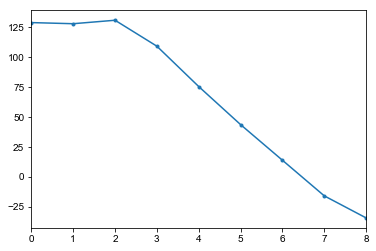

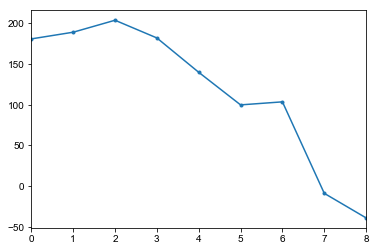

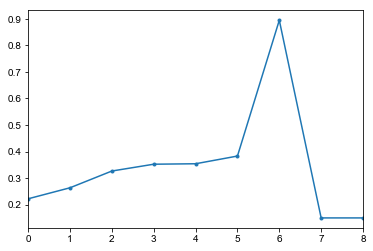

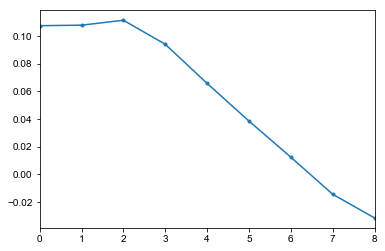

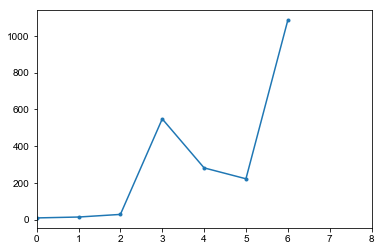

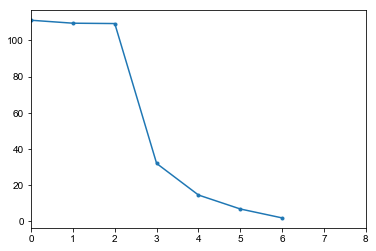

In [28]:
for name in trends:
    plt.figure()
    trends[name].plot(style='.-')
plt.show()

In [29]:
q_fraction_range = [1, 0.95, 0.9, 0.8, 0.5, 0.2, 0.1]
opts2 = pandas.DataFrame(index=pandas.MultiIndex.from_product([t_heat_reject_range,
                                                               q_fraction_range]),
                        columns=['Q','opt'])

In [ ]:
for tr,opt in zip(t_heat_reject_range, opts):
    opts2.opt[(tr,1)] = opt
    ch = system_aqua1.makeChiller(opt.x)
    opts2.loc[(tr,1),'Q'] = ch.Q_evap
    # TODO: Would like to add constraints, eventually

In [48]:
opts2

Q                                                opt
293.15 1.00  128.977  {'x': [0.222135232758, 278.663623308, 300.4146...
       0.95   88.028  {'x': [0.15, 278.45, 300.15, 301.15, 298.15, 3...
       0.90   88.028  {'x': [0.15, 278.45, 300.15, 301.15, 298.15, 3...
       0.80   88.028  {'x': [0.15, 278.45, 300.15, 301.15, 298.15, 3...
       0.50   88.028  {'x': [0.15, 278.45, 300.15, 301.15, 298.15, 3...
       0.20   88.028  {'x': [0.15, 278.45, 300.15, 301.15, 298.15, 3...
       0.10   88.028  {'x': [0.15, 278.45, 300.15, 301.15, 298.15, 3...
298.15 1.00  128.034  {'x': [0.263589863473, 278.719339224, 305.4950...
       0.95  73.7651  {'x': [0.15, 278.45, 305.15, 306.15, 303.15, 3...
       0.90  73.7651  {'x': [0.15, 278.45, 305.15, 306.15, 303.15, 3...
       0.80  73.7651  {'x': [0.15, 278.45, 305.15, 306.15, 303.15, 3...
       0.50  73.7651  {'x': [0.15, 278.45, 305.15, 306.15, 303.15, 3...
       0.20  73.7651  {'x': [0.15, 278.45, 305.15, 306.15, 303.15, 3...
       0.10  73.7651  {'x': [0.15, 278.45, 305.15, 306.15, 303.15, 3...
303.15 1.00  130.942  {'x': [0.326685131532, 278.544218108, 310.1294...
       0.95  124.452  {'x': [0.310981796873, 278.541469689, 310.1461...
       0.90  117.855  {'x': [0.294423225345, 278.545558955, 310.1476...
       0.80  104.781  {'x': [0.262326002362, 278.515551799, 310.1719...
       0.50   65.513  {'x': [0.163553490912, 278.572779872, 310.1671...
       0.20  30.4123  {'x': [0.1, 275.74014977, 312.005038803, 312.1...
       0.10  29.7424  {'x': [0.1, 275.397214471, 312.24900227, 312.3...
308.15 1.00  109.223  {'x': [0.352329015691, 278.721861477, 315.1296...
       0.95  103.763  {'x': [0.338289362176, 278.538577792, 315.1956...
       0.90  98.3329  {'x': [0.321014130277, 278.541955061, 315.2650...
       0.80  87.3793  {'x': [0.285374409377, 278.536331396, 315.1675...
       0.50  54.6065  {'x': [0.178913168805, 278.575026802, 315.2739...
       0.20  23.1359  {'x': [0.1, 276.053929325, 316.756029183, 316....
       0.10  21.2603  {'x': [0.099924333649, 275.676045056, 317.1160...
313.15 1.00  75.4407  {'x': [0.354044715611, 278.613433727, 320.1449...
       0.95  71.6481  {'x': [0.338977522311, 278.541520124, 320.1910...
...              ...                                                ...
       0.20  15.0882  {'x': [0.1, 276.883088607, 321.543780968, 321....
       0.10  10.1275  {'x': [0.1, 275.284713524, 322.249759659, 322....
318.15 1.00   43.589  {'x': [0.383060647509, 278.607631244, 325.1395...
       0.95  41.4118  {'x': [0.367573837228, 278.552183255, 325.1498...
       0.90  39.2202  {'x': [0.348019629601, 278.52989465, 325.18350...
       0.80   34.873  {'x': [0.307459383903, 278.58927791, 325.14128...
       0.50  21.7948  {'x': [0.190922431637, 278.595744064, 325.1694...
       0.20  8.71762  {'x': [0.1, 277.945051484, 325.728478513, 326....
       0.10   4.3588  {'x': [0.1, 276.913247564, 326.715232213, 326....
323.15 1.00  13.7459  {'x': [0.894702811389, 278.752871909, 329.9202...
       0.95  2.56201  {'x': [0.260071742919, 278.659958804, 330.1500...
       0.90  2.56208  {'x': [0.259967861163, 278.660047208, 330.1499...
       0.80  4.13477  {'x': [0.373396160078, 278.669798752, 330.1413...
       0.50  6.87423  {'x': [0.429199220787, 278.720029999, 329.8297...
       0.20  2.74849  {'x': [0.227432762532, 278.624589908, 330.0015...
       0.10   1.3747  {'x': [0.16461487935, 278.554317891, 330.12327...
328.15 1.00 -16.0751  {'x': [0.15, 278.45, 335.15, 336.15, 333.15, 3...
       0.95      NaN  {'x': [0.15, 278.45, 335.15, 336.15, 333.15, 3...
       0.90      NaN  {'x': [0.15, 278.45, 335.15, 336.15, 333.15, 3...
       0.80      NaN  {'x': [0.15, 278.45, 335.15, 336.15, 333.15, 3...
       0.50      NaN  {'x': [0.15, 278.45, 335.15, 336.15, 333.15, 3...
       0.20      NaN  {'x': [0.15, 278.45, 335.15, 336.15, 333.15, 3...
       0.10      NaN  {'x': [0.15, 278.45, 335.15, 336.15, 333.15, 3...
333.15 1.00  -34.541  {'x': [0.15, 278.45, 340.15, 341.15, 

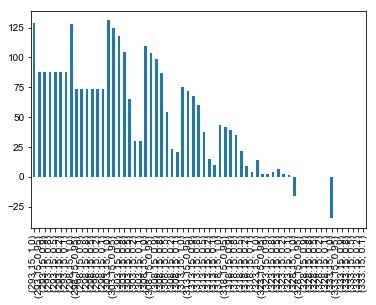

In [49]:
opts2.Q.plot.bar()
plt.show()

In [47]:
fname = 'optimize_trials2_5_data.csv'
if False:
    opts2.to_csv(fname)
if False:
    opts2 = pandas.read_csv(fname, header=0, index_col=[0,1])

In [43]:
dry_run = False
for i,index in enumerate(opts2.index):
    tr,qf = index
    q_max = opts2.Q[(tr,1)]
    q_goal = q_max * qf
    print("Case {}, T_heat_reject = {} K, Q_fraction = {}, Q_goal = {}".format(i, tr, qf, q_goal))

    if opts2.opt[index] is numpy.nan:
        xB = [400, 1, tr, 3, tr, 5, 285, 4, tr, 0.15]
        bdry = system_aqua1.makeBoundary(xB)
        P = Problem_2_5_B(bdry,q_goal)
        x = numpy.array([0.05, 278.45, tr+7, tr+8, tr+5, 395.15])
        
        if not dry_run:
            P.n_calls = 7*30
            opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                                          constraints=P.constraints,
                                          options={'disp':True,'maxiter':50,'rhobeg':0.1})
            x = opt.x
            print("First pass and we have this ... ")
            display_result(x)

            P.n_calls = 7*40
            opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                                          constraints=P.constraints,
                                          options={'disp':True,'maxiter':50,'rhobeg':0.1})
            x = opt.x
            print("Second pass and we have this ... ")
            display_result(x)

            P.n_calls = 7*50
            opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                                          constraints=P.constraints,
                                          options={'disp':True,'maxiter':50,'rhobeg':0.01})
            x = opt.x
            print("Third pass and we have this ... ")
            display_result(x)

            opts2.opt[index] = opt
        

Case 0, T_heat_reject = 293.15 K, Q_fraction = 1.0, Q_goal = 128.97739149780878
Case 1, T_heat_reject = 293.15 K, Q_fraction = 0.95, Q_goal = 122.52852192291833
Case 2, T_heat_reject = 293.15 K, Q_fraction = 0.9, Q_goal = 116.0796523480279
Case 3, T_heat_reject = 293.15 K, Q_fraction = 0.8, Q_goal = 103.18191319824703
Case 4, T_heat_reject = 293.15 K, Q_fraction = 0.5, Q_goal = 64.48869574890439
Case 5, T_heat_reject = 293.15 K, Q_fraction = 0.2, Q_goal = 25.795478299561758
Case 6, T_heat_reject = 293.15 K, Q_fraction = 0.1, Q_goal = 12.897739149780879
Case 7, T_heat_reject = 298.15 K, Q_fraction = 1.0, Q_goal = 128.0341529310197
Case 8, T_heat_reject = 298.15 K, Q_fraction = 0.95, Q_goal = 121.6324452844687
Case 9, T_heat_reject = 298.15 K, Q_fraction = 0.9, Q_goal = 115.23073763791773
Case 10, T_heat_reject = 298.15 K, Q_fraction = 0.8, Q_goal = 102.42732234481576
Case 11, T_heat_reject = 298.15 K, Q_fraction = 0.5, Q_goal = 64.01707646550985
Case 12, T_heat_reject = 298.15 K, Q_frac

C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\optimize\_minimize.py:403: RuntimeWarning: Method COBYLA does not support callback.
  warn('Method %s does not support callback.' % method, RuntimeWarning)
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


First pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,5.72709,0.819287,2.75066,33.8603
rect,7.87295,0.960658,0.200841,4.38611
abs,6.05614,0.702789,2.61655,31.4272
cond,7.44004,0.961227,1.9818,15.2884
evap,7.97508,0.980974,2.01451,17.0213
total,0,0,9.56436,0


Second pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,6.26499,0.789173,2.51655,31.2051
rect,7.85603,1.02046,0.19027,4.29907
abs,6.67732,0.665798,2.34574,28.9327
cond,7.83928,0.959161,1.64406,13.2872
evap,8.59272,0.979936,1.67436,15.0903
total,0,0,8.37098,0


Third pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,6.26363,0.789193,2.51675,31.2027
rect,7.85637,1.02045,0.190245,4.29879
abs,6.67779,0.665771,2.34551,28.9303
cond,7.8396,0.95916,1.64377,13.2853
evap,8.5948,0.979932,1.67374,15.0882
total,0,0,8.37002,0


Case 34, T_heat_reject = 313.15 K, Q_fraction = 0.1, Q_goal = 7.544068864793124
First pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,6.08967,0.786755,2.50998,30.1429
rect,8.00176,1.01782,0.179845,4.16229
abs,7.07007,0.64625,2.21055,27.9168
cond,7.97499,0.958721,1.53063,12.5547
evap,9.00294,0.979189,1.51772,14.2662
total,0,0,7.94873,0


Second pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,6.9135,0.72621,2.10067,25.445
rect,8.69924,1.01423,0.135235,3.41181
abs,8.08626,0.578394,1.81474,23.5947
cond,8.615,0.956522,1.09293,9.59766
evap,10.197,0.977092,1.04106,10.929
total,0,0,6.18463,0


Third pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,7.12759,0.709015,1.99605,24.2908
rect,8.84209,1.0131,0.124978,3.21281
abs,8.34093,0.560576,1.72294,22.5468
cond,8.74473,0.956092,0.999226,8.88994
evap,10.48,0.976592,0.941418,10.1275
total,0,0,5.78462,0


Case 35, T_heat_reject = 318.15 K, Q_fraction = 1.0, Q_goal = 43.58900444494315
Case 36, T_heat_reject = 318.15 K, Q_fraction = 0.95, Q_goal = 41.40955422269599
First pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,0.750784,0.96837,39.2066,95.2716
rect,8.10293,0.863643,0.450447,10.9836
abs,4.9843,0.700659,11.3544,88.4882
cond,5.36868,0.965172,6.28032,38.1249
evap,5.35809,0.983131,6.37499,41.4131
total,0,0,63.6668,0


Second pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,0.763847,0.967823,38.9276,95.2483
rect,8.15366,0.862466,0.448042,10.9657
abs,4.97156,0.701287,11.3683,88.4673
cond,5.36633,0.965194,6.28489,38.1388
evap,5.36267,0.983122,6.37033,41.4122
total,0,0,63.3992,0


Third pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,0.765949,0.967736,38.8796,95.2448
rect,8.16271,0.862404,0.447729,10.9632
abs,4.96921,0.70138,11.372,88.4656
cond,5.3712,0.965176,6.27989,38.1392
evap,5.35942,0.983129,6.37351,41.4118
total,0,0,63.3527,0


Case 37, T_heat_reject = 318.15 K, Q_fraction = 0.9, Q_goal = 39.23010400044883
First pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,1.62295,0.930369,27.4006,90.5576
rect,8.04606,0.864843,0.426644,10.4559
abs,4.94323,0.702878,10.6585,84.1115
cond,5.45055,0.965162,5.93025,36.2758
evap,5.47583,0.983134,6.00748,39.4209
total,0,0,50.4235,0


Second pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,1.65965,0.928671,27.0359,90.2459
rect,8.1435,0.863781,0.420963,10.3948
abs,4.9096,0.704047,10.6734,83.8333
cond,5.49597,0.965028,5.863,36.1129
evap,5.51188,0.983083,5.95008,39.2307
total,0,0,49.9434,0


Third pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,1.66448,0.928458,26.9941,90.221
rect,8.14912,0.863653,0.420586,10.3903
abs,4.90909,0.704071,10.6702,83.8103
cond,5.49626,0.965031,5.86156,36.1048
evap,5.51272,0.983083,5.94797,39.2202
total,0,0,49.8944,0


Case 38, T_heat_reject = 318.15 K, Q_fraction = 0.8, Q_goal = 34.87120355595452
First pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,3.4915,0.845982,17.0655,80.1449
rect,8.07557,0.862855,0.367854,9.24654
abs,5.00255,0.700642,9.01722,74.4264
cond,5.59056,1.10069,5.20966,32.185
evap,5.69834,0.983225,5.24338,34.9506
total,0,0,36.9036,0


Second pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,3.54588,0.843767,16.8792,80.0289
rect,8.14935,0.861969,0.365107,9.21474
abs,4.93357,0.703806,9.08162,74.3304
cond,5.61906,1.0976,5.18296,32.1662
evap,5.70746,0.983209,5.23237,34.9212
total,0,0,36.7412,0


Third pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,3.5421,0.843824,16.8697,79.978
rect,8.16238,0.862079,0.364387,9.20597
abs,4.93521,0.703513,9.0793,74.2864
cond,5.63444,1.09628,5.16348,32.1205
evap,5.71367,0.983202,5.22128,34.873
total,0,0,36.6981,0


Case 39, T_heat_reject = 318.15 K, Q_fraction = 0.5, Q_goal = 21.794502222471575
First pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,4.68903,0.800629,6.52436,50.0261
rect,8.10656,0.863116,0.215739,5.77336
abs,4.95842,0.702848,5.15285,46.457
cond,6.1643,1.19506,3.08185,20.0828
evap,6.5188,0.983156,3.06124,21.8111
total,0,0,18.036,0


Second pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,4.70545,0.800795,6.46548,49.9173
rect,8.18611,0.862044,0.214191,5.7509
abs,4.8898,0.706448,5.17632,46.3621
cond,6.18991,1.18936,3.0718,20.0975
evap,6.48562,0.983219,3.07672,21.8197
total,0,0,18.0045,0


Third pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,4.70625,0.800627,6.46232,49.8851
rect,8.19674,0.862112,0.213846,5.74591
abs,4.8902,0.70629,5.17448,46.3335
cond,6.20094,1.18759,3.06327,20.0741
evap,6.4896,0.983214,3.07178,21.7948
total,0,0,17.9857,0


Case 40, T_heat_reject = 318.15 K, Q_fraction = 0.2, Q_goal = 8.71780088898863
First pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,5.42935,0.742617,2.22971,22.2586
rect,8.04966,0.894059,0.0903903,2.51127
abs,5.64901,0.642752,2.1133,20.7765
cond,7.28601,1.39621,1.07412,7.95212
evap,7.91761,0.981888,1.07108,8.72753
total,0,0,6.57861,0


Second pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,5.43119,0.742428,2.22835,22.2457
rect,8.12801,0.886635,0.087601,2.48877
abs,5.6577,0.642276,2.11042,20.7646
cond,7.28332,1.39687,1.07608,7.96527
evap,7.91905,0.981886,1.06989,8.71916
total,0,0,6.57234,0


Third pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,5.43174,0.742385,2.22806,22.2435
rect,8.13962,0.886022,0.0873649,2.48672
abs,5.65862,0.642216,2.11007,20.7625
cond,7.28311,1.39699,1.07613,7.96557
evap,7.91958,0.981885,1.06964,8.71762
total,0,0,6.57127,0


Case 41, T_heat_reject = 318.15 K, Q_fraction = 0.1, Q_goal = 4.358900444494315
First pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,6.53143,0.619818,1.47247,15.8029
rect,8.7315,1.02684,0.0574368,1.55455
abs,6.80222,0.523999,1.50735,15.0934
cond,8.43627,1.36371,0.445883,3.78106
evap,9.2045,0.97974,0.468666,4.36257
total,0,0,3.95181,0


Second pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,6.53001,0.619788,1.47223,15.7978
rect,8.72948,1.02675,0.057402,1.55359
abs,6.80664,0.52377,1.5063,15.0888
cond,8.43427,1.36521,0.445653,3.77819
evap,9.20653,0.979737,0.468211,4.35923
total,0,0,3.94979,0


Third pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,6.53011,0.619774,1.47215,15.7972
rect,8.72974,1.02676,0.0573956,1.55345
abs,6.80659,0.523763,1.50627,15.0883
cond,8.43452,1.36515,0.445596,3.77781
evap,9.20667,0.979736,0.468158,4.3588
total,0,0,3.94957,0


Case 42, T_heat_reject = 323.15 K, Q_fraction = 1.0, Q_goal = 13.745885490702227
Case 43, T_heat_reject = 323.15 K, Q_fraction = 0.95, Q_goal = 13.058591216167114
First pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,4.67713,0.586279,1.64757,15.581
rect,7.95587,0.887797,0.0121348,0.387385
abs,5.00378,0.521512,2.23504,15.7338
cond,6.97843,0.965448,0.146919,1.02837
evap,7.77113,0.98291,0.145876,1.13402
total,0,0,4.18753,0


Second pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,4.56006,0.59931,3.22766,26.7767
rect,7.95546,0.887771,0.0259106,0.820751
abs,5.00258,0.527661,3.99122,26.9042
cond,6.93922,0.965448,0.313664,2.18686
evap,7.59516,0.983112,0.315792,2.41137
total,0,0,7.87424,0


Third pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,4.52781,0.600593,3.41612,27.9353
rect,7.95546,0.887769,0.0275438,0.871712
abs,5.00252,0.528258,4.18138,28.0548
cond,6.9342,0.965448,0.333417,2.32349
evap,7.57623,0.983132,0.336156,2.56201
total,0,0,8.29462,0


Case 44, T_heat_reject = 323.15 K, Q_fraction = 0.9, Q_goal = 12.371296941632004
First pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,4.67708,0.586287,1.64698,15.5758
rect,7.95585,0.887797,0.0121321,0.387301
abs,5.00373,0.521518,2.23423,15.7285
cond,6.97844,0.965448,0.146888,1.02815
evap,7.77115,0.98291,0.145844,1.13378
total,0,0,4.18608,0


Second pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,4.56012,0.599324,3.22678,26.7701
rect,7.9554,0.887771,0.0259093,0.820706
abs,5.00257,0.527668,3.99004,26.8974
cond,6.93918,0.965448,0.31365,2.18675
evap,7.59512,0.983112,0.315777,2.41124
total,0,0,7.87216,0


Third pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,4.52792,0.600616,3.41488,27.9259
rect,7.95545,0.887768,0.0275444,0.871729
abs,5.00239,0.528277,4.17972,28.045
cond,6.93415,0.965448,0.333429,2.32356
evap,7.57614,0.983132,0.336169,2.56208
total,0,0,8.29175,0


Case 45, T_heat_reject = 323.15 K, Q_fraction = 0.8, Q_goal = 10.996708392561782
First pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,4.6771,0.586277,1.64692,15.5756
rect,7.95587,0.887799,0.0121294,0.387216
abs,5.00383,0.521507,2.23421,15.7284
cond,6.97851,0.965448,0.146853,1.02792
evap,7.77113,0.98291,0.145811,1.13352
total,0,0,4.18592,0


Second pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,4.08825,0.699236,5.59226,39.6406
rect,7.93967,0.887822,0.0427524,1.34263
abs,4.97488,0.53281,6.28086,39.7174
cond,6.87785,0.965488,0.516812,3.58148
evap,7.49343,0.983132,0.521005,3.94929
total,0,0,12.9537,0


Third pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,4.02754,0.708673,5.86536,40.8443
rect,7.93967,0.887821,0.0447912,1.40519
abs,4.97478,0.533401,6.50326,40.9045
cond,6.87125,0.965488,0.5414,3.74972
evap,7.47235,0.983152,0.546599,4.13477
total,0,0,13.5014,0


Case 46, T_heat_reject = 323.15 K, Q_fraction = 0.5, Q_goal = 6.872942745351113


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


First pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,3.45985,0.777543,8.57041,50.4052
rect,7.77566,0.882172,0.0753906,2.31491
abs,4.83852,0.553803,8.3232,49.9569
cond,6.46135,0.967047,0.957223,6.28043
evap,7.27101,0.983237,0.92814,6.91047
total,0,0,18.8544,0


Second pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,3.48721,0.775215,8.47117,50.1227
rect,7.76641,0.882274,0.0750782,2.30396
abs,4.84848,0.553232,8.24943,49.6757
cond,6.45986,0.967059,0.953104,6.25148
evap,7.25759,0.983267,0.925679,6.87886
total,0,0,18.6745,0


Third pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,3.48955,0.775067,8.46531,50.114
rect,7.76512,0.882273,0.0750314,2.30244
abs,4.84861,0.553195,8.24814,49.668
cond,6.45902,0.967064,0.952594,6.24727
evap,7.25845,0.983266,0.924965,6.87423
total,0,0,18.666,0


Case 47, T_heat_reject = 323.15 K, Q_fraction = 0.2, Q_goal = 2.7491770981404455
First pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,4.60751,0.609855,3.09915,25.3702
rect,7.85823,0.885542,0.029676,0.933913
abs,4.92263,0.538758,3.73381,25.3512
cond,6.78818,0.966136,0.366645,2.50311
evap,7.59733,0.983071,0.360586,2.75797
total,0,0,7.58986,0


Second pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,4.61567,0.609778,3.07881,25.2408
rect,7.85325,0.88539,0.0296041,0.931501
abs,4.92055,0.538971,3.7126,25.2196
cond,6.77963,0.96618,0.366236,2.4972
evap,7.60166,0.983063,0.35952,2.75131
total,0,0,7.54677,0


Third pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,4.61762,0.609716,3.07389,25.2112
rect,7.85237,0.8854,0.0295751,0.930531
abs,4.92155,0.538915,3.70715,25.1899
cond,6.77945,0.966181,0.365871,2.49463
evap,7.60029,0.983066,0.35922,2.74849
total,0,0,7.5357,0


Case 48, T_heat_reject = 323.15 K, Q_fraction = 0.1, Q_goal = 1.3745885490702228
First pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,4.6794,0.589842,1.8928,17.4656
rect,7.9273,0.887797,0.0147774,0.470158
abs,4.98267,0.52475,2.52205,17.6054
cond,6.95227,0.965537,0.179146,1.24964
evap,7.74316,0.982938,0.177739,1.37805
total,0,0,4.78651,0


Second pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,4.6651,0.591043,1.87982,17.3149
rect,7.91574,0.887804,0.0147922,0.470421
abs,4.98641,0.524873,2.49535,17.4496
cond,6.94447,0.965574,0.179374,1.24984
evap,7.75175,0.98292,0.177573,1.3783
total,0,0,4.74691,0


Third pass and we have this ... 


name,deltaT,epsilon,UA,Q
gen,4.66502,0.590963,1.87755,17.2997
rect,7.91501,0.887821,0.0147548,0.469222
abs,4.98716,0.524786,2.493,17.4349
cond,6.94461,0.965574,0.178902,1.24657
evap,7.75244,0.98292,0.177097,1.3747
total,0,0,4.7413,0


Case 49, T_heat_reject = 328.15 K, Q_fraction = 1.0, Q_goal = -16.075082206722065
Case 50, T_heat_reject = 328.15 K, Q_fraction = 0.95, Q_goal = -15.271328096385961
First pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Second pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Third pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Case 51, T_heat_reject = 328.15 K, Q_fraction = 0.9, Q_goal = -14.467573986049858
First pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Second pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Third pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Case 52, T_heat_reject = 328.15 K, Q_fraction = 0.8, Q_goal = -12.860065765377653
First pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Second pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Third pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Case 53, T_heat_reject = 328.15 K, Q_fraction = 0.5, Q_goal = -8.037541103361033
First pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Second pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Third pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Case 54, T_heat_reject = 328.15 K, Q_fraction = 0.2, Q_goal = -3.2150164413444133
First pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Second pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Third pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Case 55, T_heat_reject = 328.15 K, Q_fraction = 0.1, Q_goal = -1.6075082206722067
First pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Second pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Third pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Case 56, T_heat_reject = 333.15 K, Q_fraction = 1.0, Q_goal = -34.54102430776841
Case 57, T_heat_reject = 333.15 K, Q_fraction = 0.95, Q_goal = -32.81397309237999
First pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Second pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Third pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Case 58, T_heat_reject = 333.15 K, Q_fraction = 0.9, Q_goal = -31.08692187699157
First pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Second pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Third pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Case 59, T_heat_reject = 333.15 K, Q_fraction = 0.8, Q_goal = -27.63281944621473
First pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Second pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Third pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Case 60, T_heat_reject = 333.15 K, Q_fraction = 0.5, Q_goal = -17.270512153884205
First pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Second pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Third pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Case 61, T_heat_reject = 333.15 K, Q_fraction = 0.2, Q_goal = -6.908204861553682
First pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Second pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Third pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Case 62, T_heat_reject = 333.15 K, Q_fraction = 0.1, Q_goal = -3.454102430776841
First pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Second pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

Third pass and we have this ... 


ValueError('In rectifier, net mass or ammonia flow is negative.')

In [46]:
dry_run = False
for i,index in enumerate(opts2.index):
    tr,qf = index
    q_max = opts2.Q[(tr,1)]
    q_goal = q_max * qf
    print("Case {}, T_heat_reject = {} K, Q_fraction = {}, Q_goal = {}".format(i, tr, qf, q_goal))

    if opts2.opt[index] is not numpy.nan and opts2.Q[index] is numpy.nan:
        try:
            xB = [400, 1, tr, 3, tr, 5, 285, 4, tr, 0.15]
            bdry = system_aqua1.makeBoundary(xB)
            x = opts2.opt[index].x
            ch = system_aqua1.makeChiller(x)
            sys = system_aqua1.System(bdry, ch)
            opts2.Q[index] = ch.Q_evap
        except KeyboardInterrupt:
            raise
        except:
            pass

Case 0, T_heat_reject = 293.15 K, Q_fraction = 1.0, Q_goal = 128.97739149780878
Case 1, T_heat_reject = 293.15 K, Q_fraction = 0.95, Q_goal = 122.52852192291833


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


Case 2, T_heat_reject = 293.15 K, Q_fraction = 0.9, Q_goal = 116.0796523480279
Case 3, T_heat_reject = 293.15 K, Q_fraction = 0.8, Q_goal = 103.18191319824703
Case 4, T_heat_reject = 293.15 K, Q_fraction = 0.5, Q_goal = 64.48869574890439
Case 5, T_heat_reject = 293.15 K, Q_fraction = 0.2, Q_goal = 25.795478299561758
Case 6, T_heat_reject = 293.15 K, Q_fraction = 0.1, Q_goal = 12.897739149780879
Case 7, T_heat_reject = 298.15 K, Q_fraction = 1.0, Q_goal = 128.0341529310197
Case 8, T_heat_reject = 298.15 K, Q_fraction = 0.95, Q_goal = 121.6324452844687
Case 9, T_heat_reject = 298.15 K, Q_fraction = 0.9, Q_goal = 115.23073763791773
Case 10, T_heat_reject = 298.15 K, Q_fraction = 0.8, Q_goal = 102.42732234481576
Case 11, T_heat_reject = 298.15 K, Q_fraction = 0.5, Q_goal = 64.01707646550985
Case 12, T_heat_reject = 298.15 K, Q_fraction = 0.2, Q_goal = 25.60683058620394
Case 13, T_heat_reject = 298.15 K, Q_fraction = 0.1, Q_goal = 12.80341529310197
Case 14, T_heat_reject = 303.15 K, Q_fract

In [159]:
P.n_calls = 7 * numpy.floor(P.n_calls / 7)
opt = scipy.optimize.minimize(P.objective, x2, method="COBYLA",
                              constraints=P.constraints, callback=P.callback,
                              options={'disp':True,'maxiter':100,'rhobeg':0.01})
opt

[  3.23139528e-01   2.78641275e+02   3.12291755e+02   3.13259021e+02
   3.10228713e+02   3.95250062e+02]


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\optimize\_minimize.py:403: RuntimeWarning: Method COBYLA does not support callback.
  warn('Method %s does not support callback.' % method, RuntimeWarning)


Note: Absorber inlet is subcooled


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


176.0 25.0 138.19835208991435 0.118474468961 0.0 

[  3.33139528e-01   2.78641275e+02   3.12291755e+02   3.13259021e+02
   3.10228713e+02   3.95250062e+02]
Note: Absorber inlet is subcooled
177.0 25.0 153.19282242496664 1.65573909183 0.0 

[  3.23139528e-01   2.78651275e+02   3.12291755e+02   3.13259021e+02
   3.10228713e+02   3.95250062e+02]
Note: Absorber inlet is subcooled
178.0 25.0 138.537420450732 0.137721707638 0.0 

[  3.23139528e-01   2.78641275e+02   3.12301755e+02   3.13259021e+02
   3.10228713e+02   3.95250062e+02]
Note: Absorber inlet is subcooled
179.0 25.0 138.02564423858303 0.11642563615 0.0 

[  3.23139528e-01   2.78641275e+02   3.12301755e+02   3.13269021e+02
   3.10228713e+02   3.95250062e+02]
Note: Absorber inlet is subcooled
180.0 25.0 138.02541019578706 0.11642563615 0.0 

[  3.23139528e-01   2.78641275e+02   3.12301755e+02   3.13269021e+02
   3.10238713e+02   3.95250062e+02]
Note: Absorber inlet is subcooled
181.0 25.0 137.76089753239407 0.113325785726 1.90304608

218.0 31.0 137.93492603309292 6.27051179198e-05 0.0 

[  3.23510692e-01   2.78637994e+02   3.12304854e+02   3.13272145e+02
   3.10228865e+02   3.95249905e+02]
Note: Absorber inlet is subcooled
219.0 31.0 138.3437832789862 7.28263703382e-05 0.0 

[  3.23043078e-01   2.78637989e+02   3.12304881e+02   3.13272146e+02
   3.10228874e+02   3.95249904e+02]
Note: Absorber inlet is subcooled
220.0 31.0 137.7298352782445 5.81412976511e-05 30.2527135588 

[  3.23298881e-01   2.78637994e+02   3.12304871e+02   3.13272146e+02
   3.10228869e+02   3.95249905e+02]
Note: Absorber inlet is subcooled
221.0 31.0 138.0648716512608 6.57668283439e-05 0.0 

[  3.23200198e-01   2.78637994e+02   3.12304878e+02   3.13272146e+02
   3.10228921e+02   3.95249905e+02]
Note: Absorber inlet is subcooled
222.0 31.0 137.93406342834837 6.27004958696e-05 0.0 

[  3.23100284e-01   2.78637991e+02   3.12304880e+02   3.13272146e+02
   3.10228923e+02   3.95249904e+02]
Note: Absorber inlet is subcooled
223.0 31.0 137.8032564948898

     fun: 154.21286840036998
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 52
  status: 1
 success: True
       x: array([  3.23096349e-01,   2.78637991e+02,   3.12304830e+02,
         3.13272146e+02,   3.10228923e+02,   3.95249904e+02])

In [182]:
x2 = opt.x
x2

array([  3.23096349e-01,   2.78637991e+02,   3.12304830e+02,
         3.13272146e+02,   3.10228923e+02,   3.95249904e+02])

In [161]:
ch2 = system_aqua1.makeChiller(x2)
display(ch2)

,T,P,x,h,s,u,v,Qu
rich_abs_outlet,310.229,4.99213,0.517237,-72.9791,0.394813,-73.5949,0.00123348,0
rich_pump_outlet,310.394,15.1992,0.517237,-71.4056,0.395827,-73.2797,0.00123301,-0.001
rich_shx_outlet,350.055,15.1992,0.517237,110.147,0.946042,108.164,0.00130451,-0.001
rich_gen_sat_liquid,351.206,15.1992,0.517237,115.56,0.961482,113.573,0.00130711,0
weak_gen_outlet,395.25,15.1992,0.300604,347.435,1.53761,345.533,0.00125114,0
weak_shx_outlet,336.536,15.1992,0.300604,84.3913,0.817873,82.6393,0.0011527,-0.001
weak_exp_outlet,336.713,4.99213,0.300604,84.3913,0.821369,83.8154,0.00115351,-0.001
gen_vapor_outlet,351.206,15.1992,0.988756,1421.67,4.56463,1266.29,0.102232,1
gen_reflux_inlet,351.206,15.1992,0.517235,115.557,0.961473,113.57,0.00130711,0
refrig_rect_outlet,313.272,15.1992,0.999869,1293.92,4.18118,1164.05,0.0854417,0.997783


In [162]:
P.constraint(x2)

[0.22309634851689678,
 0.67690365148310327,
 32.666838464731313,
 0.86731647569055215,
 21.590932006864364,
 80.97775799049748,
 84.020980924054982]

In [163]:
sys2 = system_aqua1.System(bdry, ch2)
sys2

Note: Absorber inlet is subcooled


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


name,deltaT,epsilon,UA,Q
gen,4.75025,0.92018,28.5516,187.274
rect,8.15244,0.782637,1.12489,15.8689
abs,1.1977,0.940514,42.4473,178.135
cond,2.31615,0.96672,26.5502,110.824
evap,0.749386,0.983799,39.125,117.045
total,0,0,137.799,0


In [183]:
box = numpy.ones_like(x2)
box[0] = 0.05
ss = numpy.linspace(-1,1,5)
yyy = numpy.zeros([len(box),len(ss)])
for i,boxi in enumerate(box):
    yy = numpy.zeros_like(ss)
    for j, s in enumerate(ss):
        x_vary = x2.copy()
        x_vary[i] += boxi * s
        yyy[i,j] = P.objective_raw(x_vary)
        if (numpy.array(P.constraint(x_vary)) < 0).any():
            yyy[i,j] = numpy.nan

Note: Absorber inlet is subcooled


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled


In [184]:
yyy

array([[  92.85015493,  111.63476306,  137.79899444,  191.02442712,
                  inf],
       [ 116.37203437,  125.02773452,  137.79899444,  170.21816617,
                  inf],
       [ 160.89854932,  147.57478175,  137.79899444,  130.09642707,
                  nan],
       [          nan,  137.81416839,  137.79899444,  137.78949491,
         137.78336925],
       [ 209.06261669,  155.59632572,  137.79899444,  126.91870377,
         119.04386542],
       [ 129.11684491,  133.29755777,  137.79899444,  142.67851534,
         148.01130393]])

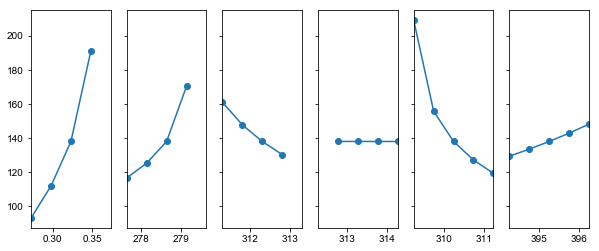

In [187]:
plt.close('all')
plt.figure(figsize=(10, 4))
ax1=plt.subplot(1,len(box), 1)
for i,_ in enumerate(box):
    ax=plt.subplot(1, len(box), i+1, sharey=ax1)
    xxx = x2[i] + ss * box[i]
    plt.plot(xxx, yyy[i,:], 'o-')
    plt.setp(ax.get_yticklabels(), visible=bool(i==0))
    plt.xlim(min(xxx),max(xxx))
#plt.ylim(min(yyy.flat)*0.9,min(yyy.flat))
plt.show()

The sensitivity plot could go further by overlaying the constraint functions. Additionally, it would be nice to find the eigenvectors of the objective function and trace in those directions, indicating how far it is to the next constraint. But that is icing on the cake, so meanwhile I will continue with this approach in a new notebook and generate some parametric study data.

# Scratch work

In [15]:
a=5
for i in range(9999):
    a*=0.5
    if a==0:
        break
i,a

(1076, 0.0)

In [25]:
gradient_step = numpy.array([1.,2.,3.,4.])
for j, _ in enumerate(gradient_step):
    for i in range(2):
        gradient_step[j] *= 0.5
gradient_step

array([ 0.25,  0.5 ,  0.75,  1.  ])

In [30]:
numpy.diag(gradient_step)[3]

array([ 0.,  0.,  0.,  1.])

In [3]:
%%html
<pre id="TOC-markdown">TOC will be here</pre>
<script>
$("#TOC-markdown").html(
    $('h1,h2,h3,h4').filter(":has(a)").map(function(){return "  ".repeat($(this).prop("tagName")[1]) + "- ["+$(this).text()+"](" + $(this).children().attr("href") + ")";}).get().join("\n")
    );
</script>